In [84]:
import numpy as np
import sys

sys.path.append('..')
from data.smoothing import smooth_pend
from utils.normalize import normalize_pend
from data.pendulum import pendulum_train_data, pendulum_test_data
from data.pde_recovery import sample_idxs, load_and_shift_pend_data, optimal_recovery, rbf_vector_kernel, cross_validation, rhs, mse_loss, cross_validation_lengthscale, cross_validation_nugget
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale

In [85]:
# Perform the PDE learning step for the pendulum data

I = 40  # Number of pendulums we're running
results, f = pendulum_train_data(I=I, noise=0)
test_results, f_test = pendulum_test_data(I=50, noise=0.01)

# normalized_train_results, normalized_train_f, scalers = normalize_pend(results, f)
# normalized_test_results, normalized_test_f, test_scalers = normalize_pend(test_results, f_test)

sample = sample_idxs()
S_train, f_train, t_train = load_and_shift_pend_data(results, f, sample, .1, .0001)
S_test, f_test, t_test = load_and_shift_pend_data(test_results, f_test, sample, .1, .0001)

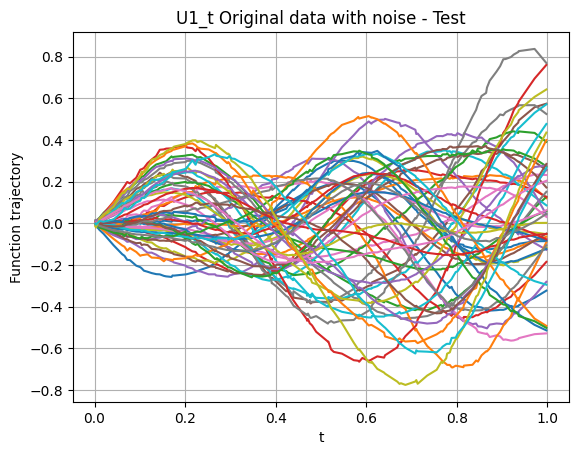

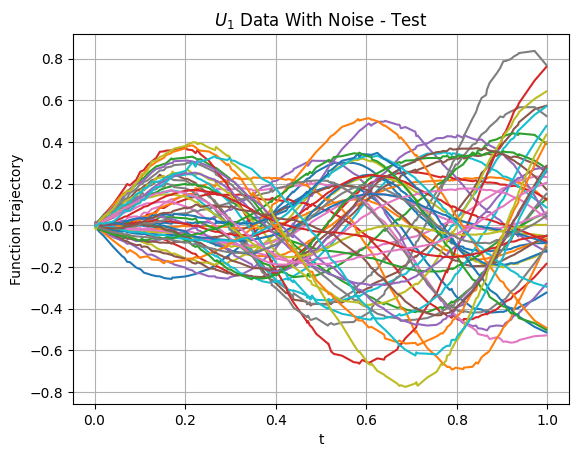

(2, 109, 5, 50)


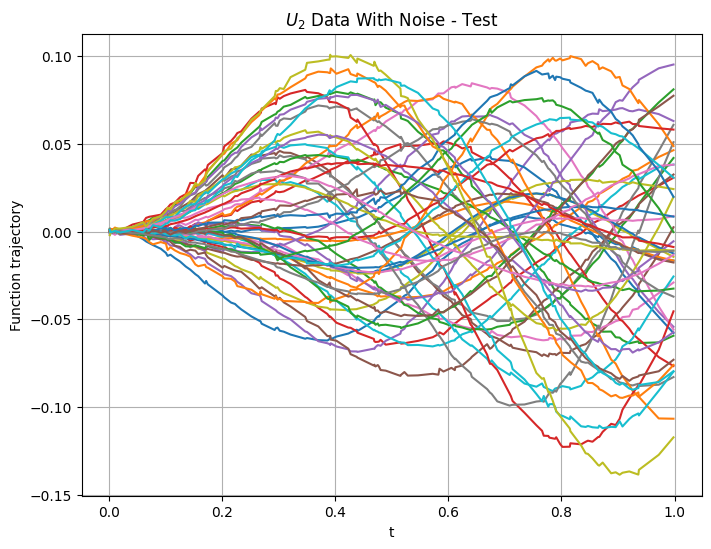

In [90]:
# original vs smoothed
plt.plot(t_test, test_results[:, 1, sample].T)
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Original data with noise - Test')
plt.grid(True)
plt.show()

#Plot original vs smoothed
plt.plot(t_test, test_results[:, 1, sample].T)
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('$U_1$ Data With Noise - Test')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

print(S_test.shape)
plt.plot(t_test, test_results[:,0,sample].T)
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('$U_2$ Data With Noise - Test')
plt.grid(True)
plt.show()


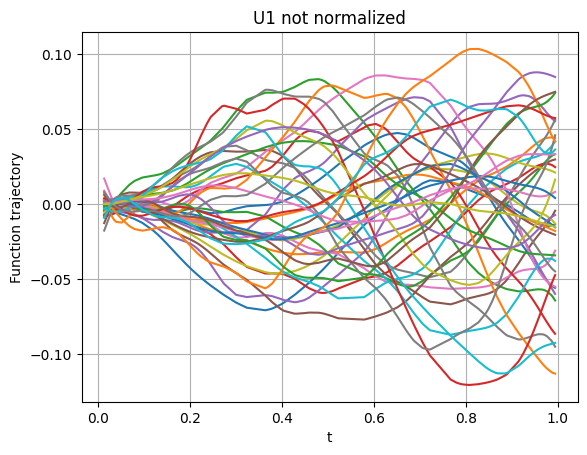

In [57]:
plt.plot(t_test, S_train[0,:,0,:])
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1 not normalized')
plt.grid(True)
plt.show()

In [91]:
for i in range(2):
    S_train[0,:,i,:] = minmax_scale(S_train[0,:,i,:])
S_train[1, :, 0, :] = minmax_scale(S_train[1, :, 0, :])

In [119]:
S_test[0,:,0,:] = minmax_scale(S_test[0,:,0,:])

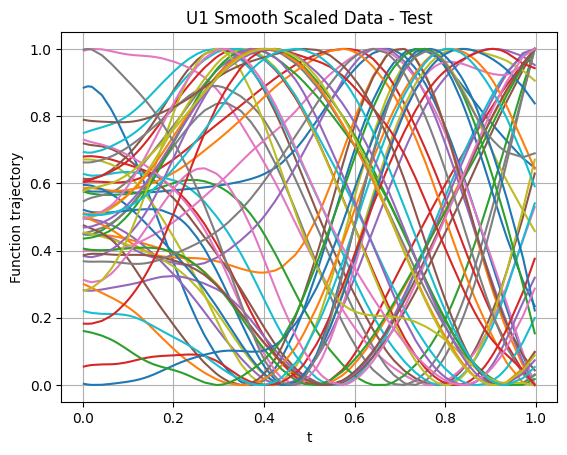

In [121]:
plt.plot(t_test, S_test[0,:,0,:])
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1 Smooth Scaled Data - Test')
plt.grid(True)
plt.show()

In [94]:
lengthscale_values_u1 = np.linspace(1e-6, 4, 100) # Chosen based on preliminary result of .1 (and subsequently .01) being best for a coarse search
nugget_values_u1 = np.linspace(1e-4, 1, 20) # Chosen based on preliminary result of .7 being best for a coarse search

In [95]:
# Cross validation with each param varying separately
# mse1_l_u1= cross_validation_lengthscale(S_train[0],  S_train[1, :, 0, :].T, lengthscale_values_u1)
# mse1_nu_u1 = cross_validation_nugget(S_train[0],  S_train[1, :, 0, :].T, nugget_values_u1)

In [96]:
# Plot cross-validation curve
# plt.plot(lengthscale_values_u1, mse1_l)
# plt.xlabel('Lengthscale')
# plt.ylabel('Cross-validation MSE')
# plt.title('Cross-validation Curve')
# plt.grid(True)
# plt.show()

# # get the optimal lengthscale
# optimal_lengthscale = lengthscale_values[np.argmin(mse1_l)]
# print("Optimal lengthscale:", optimal_lengthscale)

In [97]:
# Plot cross-validation curve
# plt.plot(nugget_values_u1, mse1_nu)
# plt.xlabel('Lengthscale')
# plt.ylabel('Cross-validation MSE')
# plt.title('Cross-validation Curve')
# plt.grid(True)
# plt.show()

# # get the optimal lengthscale
# optimal_nu = nugget_values_u1[np.argmin(mse1_nu)]
# print("Optimal nu:", optimal_nu)

In [98]:
# Cross validation with 2 varying params
print(S_train.shape)
print(S_train[1, :, 0, :].T.shape)
mse_surface_u1 = cross_validation(S_train[0, :, :2, :],  S_train[1, :, 0, :].T, lengthscale_values_u1, nugget_values_u1)

(2, 109, 5, 40)
(40, 109)


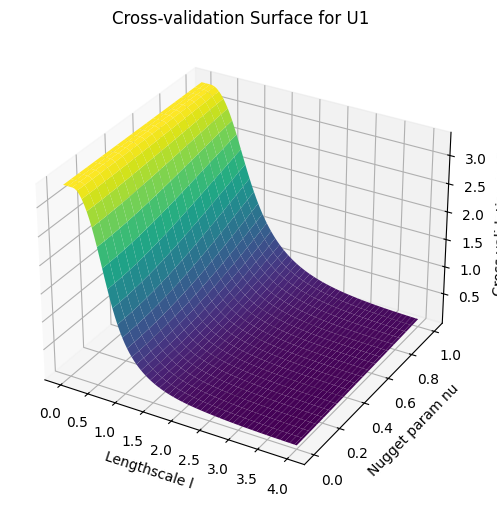

Indices of the minimum value: (99, 0)
l minimum value: 4.0
nu minimum value: 0.0001
Minimum value: 0.01954815929542746


In [99]:
# Plot cross-validation surface
L1, L2 = np.meshgrid(lengthscale_values_u1, nugget_values_u1)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(L1, L2, mse_surface_u1.T, cmap='viridis')
ax.set_xlabel('Lengthscale l')
ax.set_ylabel('Nugget param nu')
ax.set_zlabel('Cross-validation MSE')
ax.set_title('Cross-validation Surface for U1')
plt.show()

min_index_u1 = np.unravel_index(np.argmin(mse_surface_u1), mse_surface_u1.shape)

print("Indices of the minimum value:", min_index_u1)
print("l minimum value:", lengthscale_values_u1[min_index_u1[0]])
print("nu minimum value:", nugget_values_u1[min_index_u1[1]])
print("Minimum value:", mse_surface_u1[min_index_u1])

In [100]:
mse_surface_u1.shape

(100, 20)

Text(4, 0.07, '(4, 0.016)')

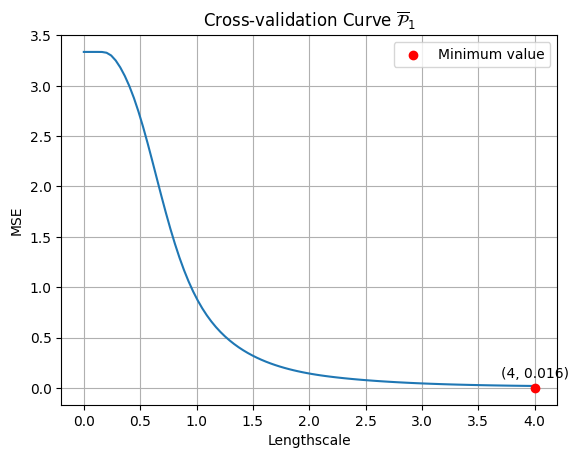

In [101]:
plt.title("Cross-validation Curve $\overline{\mathcal{P}}_1$")
plt.plot(lengthscale_values_u1, mse_surface_u1[:,1])
plt.xlabel("Lengthscale")
plt.ylabel("MSE")
plt.grid()
plt.scatter(4, 0.001, color='red', zorder=5, label='Minimum value')
plt.legend()
plt.text(4, 0.07, '(4, 0.016)', fontsize=10, verticalalignment='bottom', horizontalalignment='center')

In [122]:
lengthscale_values_u2 = np.linspace(0.0001, 10, 100) # Chosen based on preliminary result of .1 (and subsequently .01) being best for a coarse search
nugget_values_u2 = np.linspace(1e-4, 1, 10) # Chosen based on preliminary result of .7 being best for a coarse search

In [123]:
for i in range(2):
    S_train[1,:,i,:] = minmax_scale(S_train[1,:,i,:])
f_train = minmax_scale(f_train)

In [124]:
mse_surface_u2 = cross_validation(S_train[1, :, :2, :], rhs(S_train[0, :, 0, :].T, f_train), lengthscale_values_u2, nugget_values_u2)

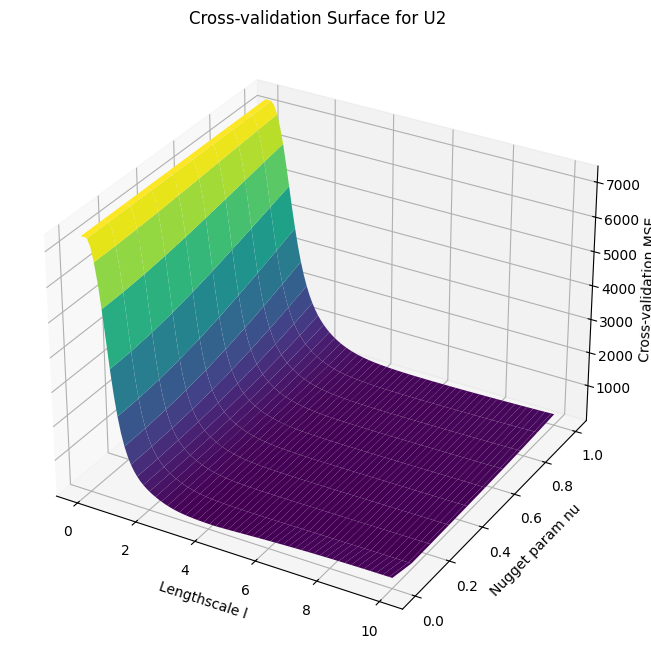

Indices of the minimum value: (51, 1)
l minimum value: 5.151563636363636
nu minimum value: 0.11120000000000001
Minimum value: 82.92636533214251


In [125]:
# Plot cross-validation surface
L1, L2 = np.meshgrid(lengthscale_values_u2, nugget_values_u2)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(L1, L2, mse_surface_u2.T, cmap='viridis')
ax.set_xlabel('Lengthscale l')
ax.set_ylabel('Nugget param nu')
ax.set_zlabel('Cross-validation MSE')
ax.set_title('Cross-validation Surface for U2')
plt.show()

min_index_u2 = np.unravel_index(np.argmin(mse_surface_u2), mse_surface_u2.shape)

print("Indices of the minimum value:", min_index_u2)
print("l minimum value:", lengthscale_values_u2[min_index_u2[0]])
print("nu minimum value:", nugget_values_u2[min_index_u2[1]])
print("Minimum value:", mse_surface_u2[min_index_u2])

Text(4, 200, '(4, 87)')

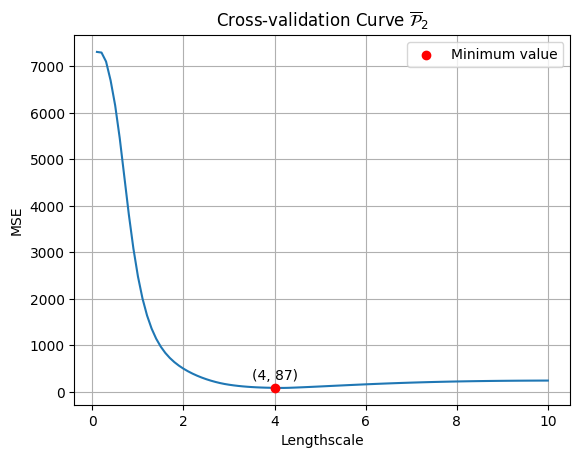

In [106]:
plt.title("Cross-validation Curve $\overline{\mathcal{P}}_2$")
plt.plot(lengthscale_values_u2, mse_surface_u2[:,0])
plt.xlabel("Lengthscale")
plt.ylabel("MSE")
plt.grid()
plt.scatter(4, 87.011, color='red', zorder=5, label='Minimum value')
plt.legend()
plt.text(4, 200, '(4, 87)', fontsize=10, verticalalignment='bottom', horizontalalignment='center')

In [107]:
for i in range(2):
    S_test[1, :, i, :] = minmax_scale(S_test[1, :, i, :])
    S_test[0, :, i, :] = minmax_scale(S_test[0, :, i, :])


In [108]:
P_hat1_train = optimal_recovery(S_train[0, :, :2, :], S_train[1, :, 0, :].T, S_train[0, :, :2, :], lengthscale_values_u1[min_index_u1[0]], nugget_values_u1[min_index_u1[1]]) #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat1 = optimal_recovery(S_train[0, :, :2, :], S_train[1, :, 0, :].T, S_test[0, :, :2, :], lengthscale_values_u1[min_index_u1[0]], nugget_values_u1[min_index_u1[1]]) #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat2_train = optimal_recovery(S_train[1, :, :2, :], rhs(S_train[0, :, 0, :].T, f_train), S_train[1, :, :2, :], lengthscale_values_u2[min_index_u2[0]], nugget_values_u2[min_index_u2[1]]) #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat2 = optimal_recovery(S_train[1, :, :2, :], rhs(S_train[0, :, 0, :].T, f_train), S_test[1, :, :2, :], lengthscale_values_u2[min_index_u2[0]], nugget_values_u2[min_index_u2[1]]) #P(rhs(train)) = u2  u2(test) = P(rhs(train)(test)

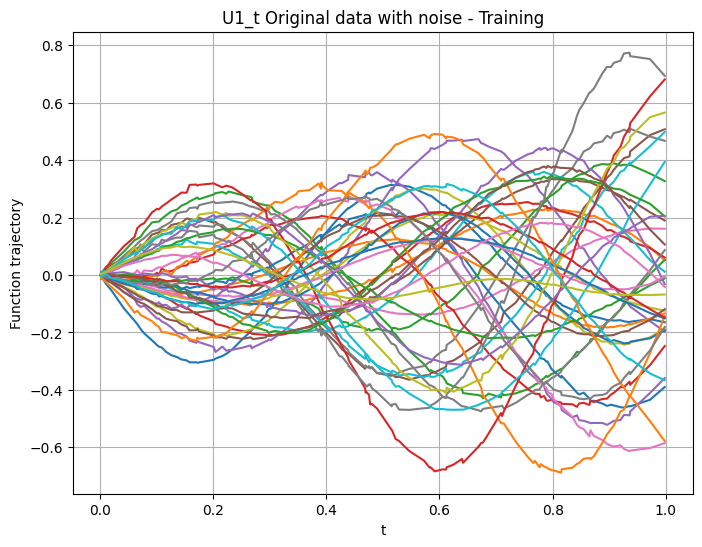

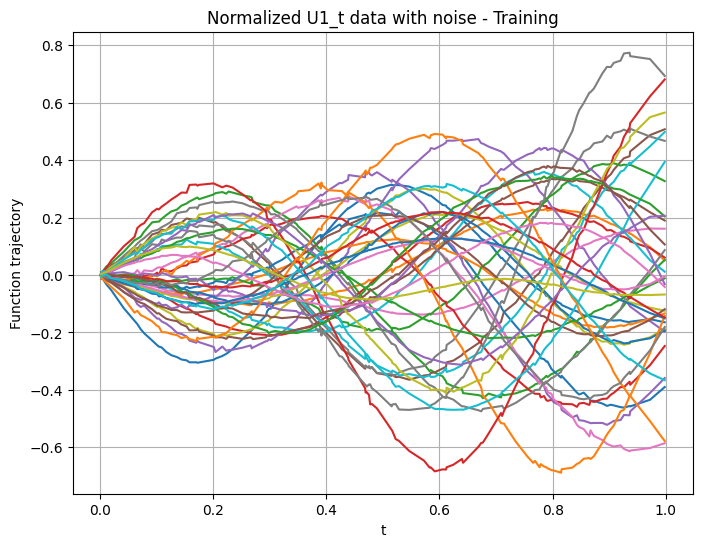

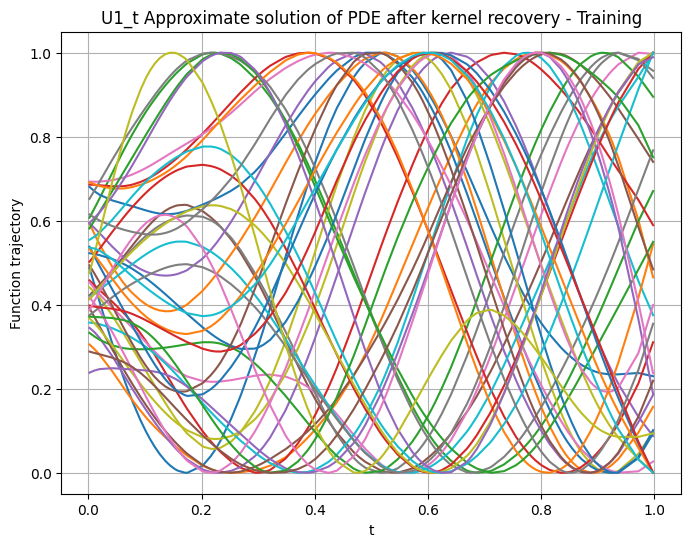

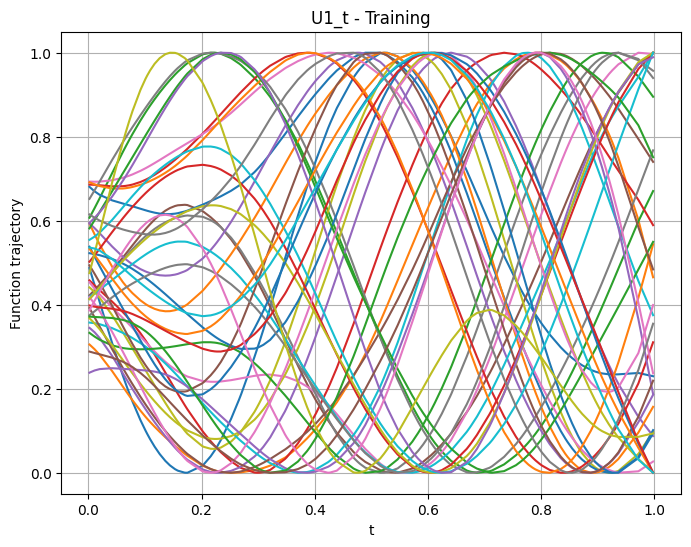

In [109]:
# Results on the train set look quite smooth
plt.figure(figsize=(8, 6))

plt.plot(t_train, results[:, 1, sample].T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Original data with noise - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, results[:, 1, sample].T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Normalized U1_t data with noise - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, P_hat1_train.T) #u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Approximate solution of PDE after kernel recovery - Training')
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 6))

plt.plot(t_train, S_train[1, :, 0, :]) #u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t - Training')
plt.grid(True)
plt.show()

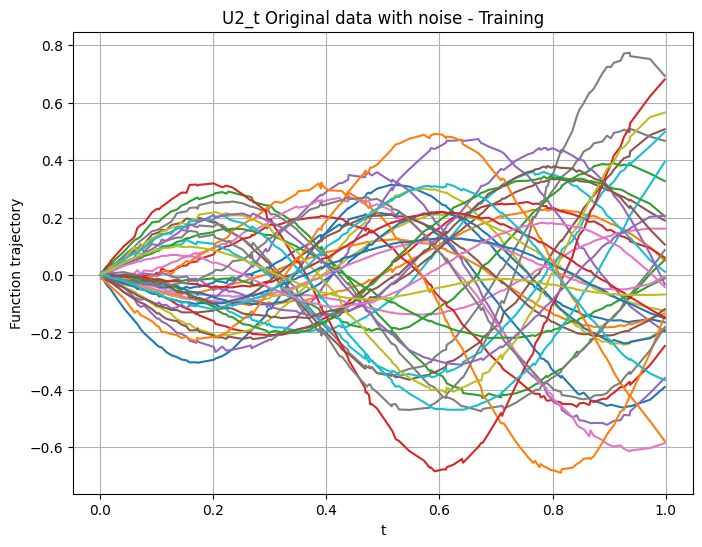

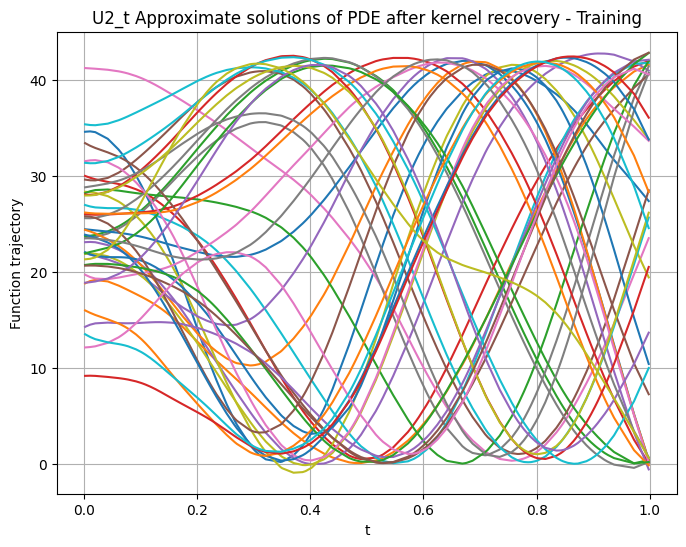

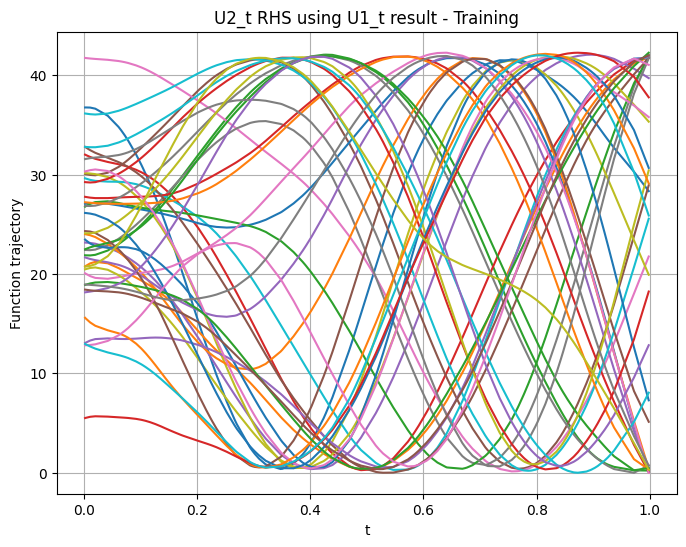

In [110]:
# Results on the train set look quite smooth
plt.figure(figsize=(8, 6))

plt.plot(t_train, results[:, 1, sample].T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Original data with noise - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, P_hat2_train.T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t Approximate solutions of PDE after kernel recovery - Training')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, rhs(S_train[0, :, 0, :].T, f_train).T) # u1 
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U2_t RHS using U1_t result - Training')
plt.grid(True)
plt.show()

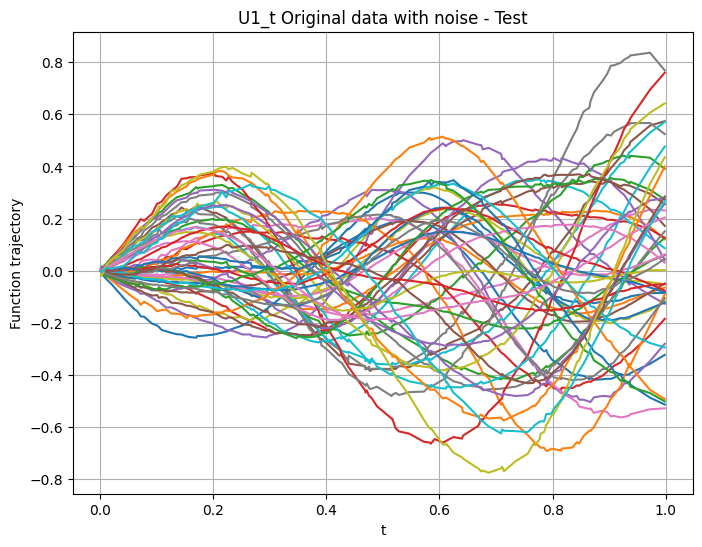

(2, 109, 5, 50)


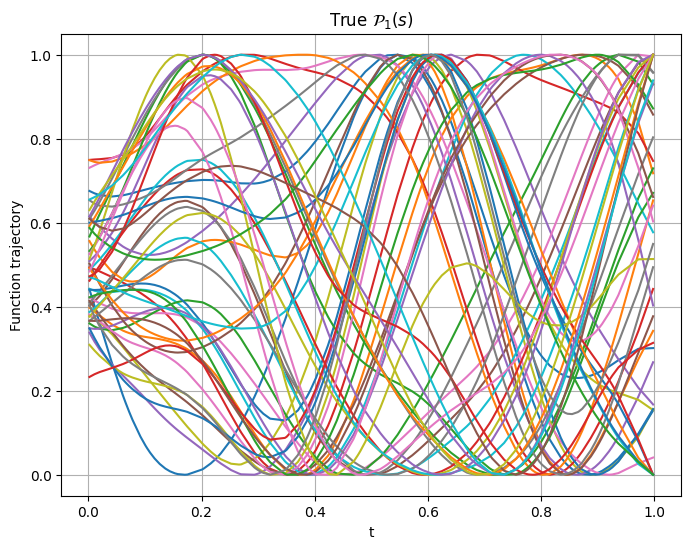

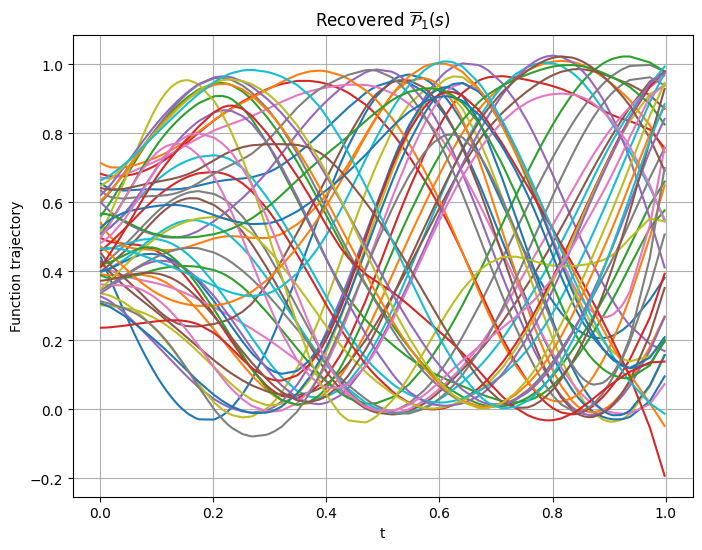

In [115]:
plt.figure(figsize=(8, 6))

plt.plot(t_test, test_results[:, 1, sample].T)
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('U1_t Original data with noise - Test')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

print(S_test.shape)
plt.plot(t_test, S_test[1, :, 0, :])
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('True $\mathcal{P}_1(s)$')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_test, P_hat1.T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Recovered $\overline{\mathcal{P}}_1(s)$')
plt.grid(True)
plt.show()

In [112]:
# Plot the differences of the RHS of pendulum eqn and p_hat, the estimator

(2, 109, 5, 50)


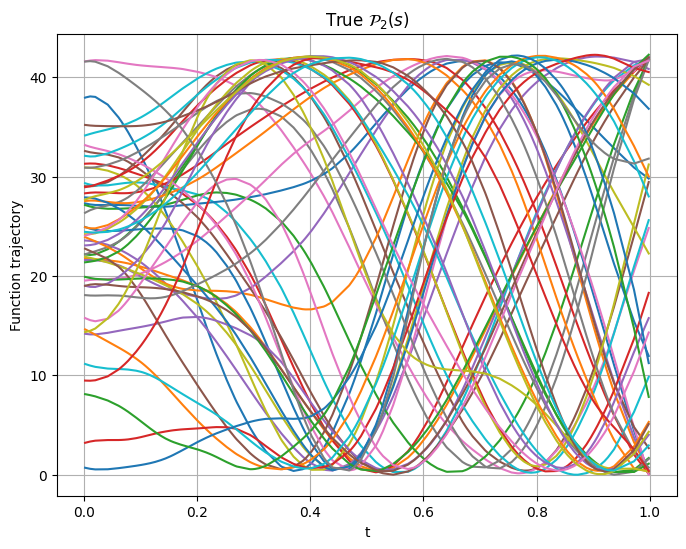

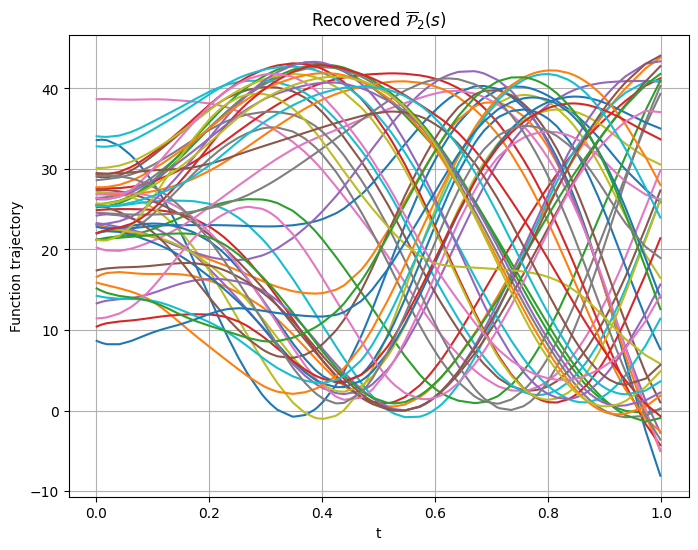

In [116]:
plt.figure(figsize=(8, 6))
f_test = minmax_scale(f_test)
print(S_test.shape)
plt.plot(t_test, rhs(S_test[0, :, 0, :].T, f_test).T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('True $\mathcal{P}_2(s)$')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_test, P_hat2.T) # u2t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Recovered $\overline{\mathcal{P}}_2(s)$')
plt.grid(True)
plt.show()

In [128]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(P_hat1.T, S_test[1, :, 0, :]))
print(mean_squared_error(P_hat2.T, rhs(S_test[0, :,0, :], f_test.T)))

0.0018470800336356182
9.23609736263071


(2, 109, 5, 50)


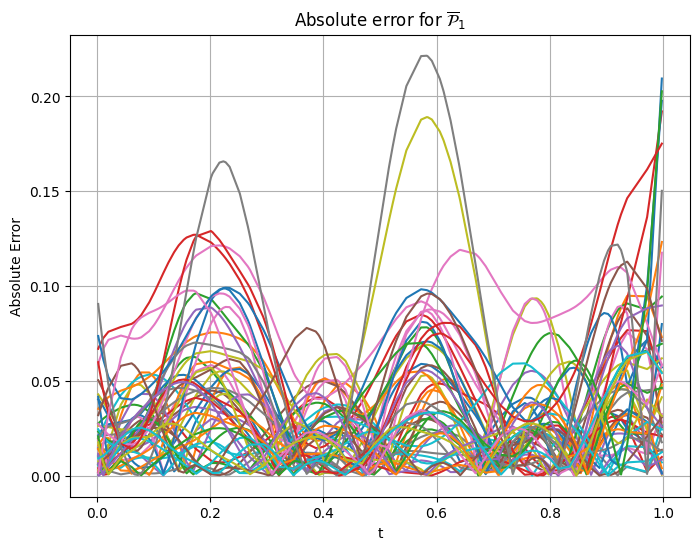

(2, 109, 5, 50)


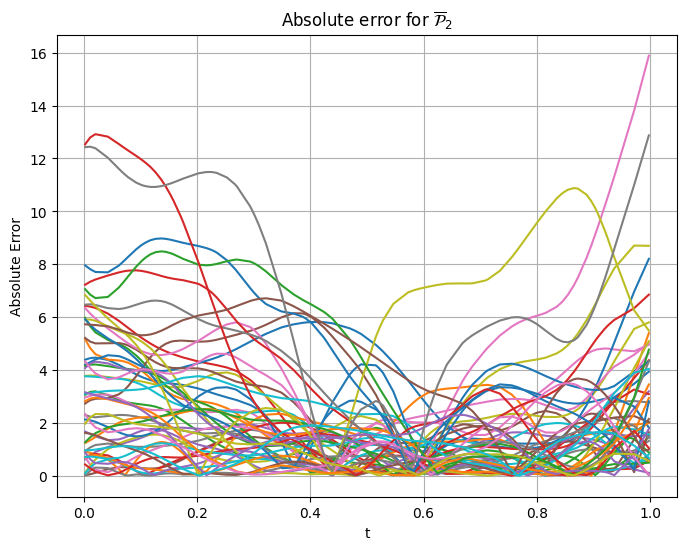

In [114]:
absolute_error_u1 = abs(P_hat1.T -  S_test[1, :, 0, :])

plt.figure(figsize=(8, 6))

print(S_test.shape)
plt.plot(t_test, absolute_error_u1) # u2
plt.xlabel('t')
plt.ylabel('Absolute Error')
plt.title('Absolute error for $\overline{\mathcal{P}}_1$')
plt.grid(True)
plt.show()

absolute_error_u2 = abs(P_hat2.T - rhs(S_test[0, :,0, :], f_test.T))

plt.figure(figsize=(8, 6))

print(S_test.shape)
plt.plot(t_test, absolute_error_u2) # u2
plt.xlabel('t')
plt.ylabel('Absolute Error')
plt.title('Absolute error for $\overline{\mathcal{P}}_2$')
plt.grid(True)
plt.show()
